In [1]:
import ROOT, os, sys, glob
from math import *
ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.0.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_JPsiToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root']

In [3]:
rdf = ROOT.RDataFrame("Events","/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root")

In [5]:
#rdf.Describe()

Processed 10000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


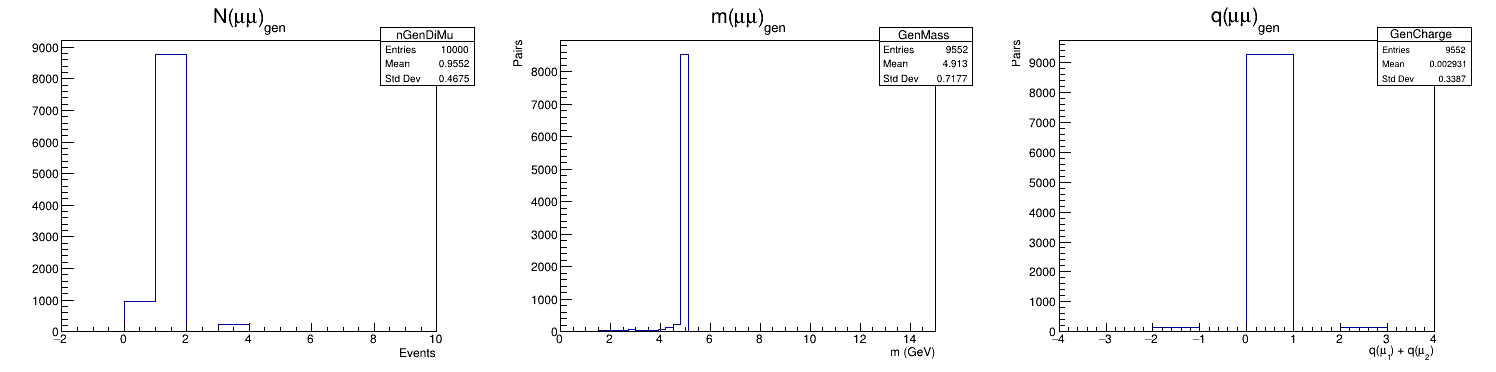

In [17]:
def makeDimuonPairs(name, rdf):
    ## define 4-vectors in cartesian coordinates, for easier 
    rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
    ## make indices of all the pairs
    rdf = rdf.Define(f"{name}DiMu_indices", f"""
        ROOT::VecOps::RVec<std::pair<int,int>> ret; 
        for (int i = 0, n = n{name}Mu; i < n; ++i) 
            for (int i2 = i+1; i2 < n; ++i2) 
                ret.emplace_back(i,i2);
        return ret;""")
    
    #Let us impose a selection criteria here
    
    
    ## Make the number of dimuons, for convenience later
    rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
    ## compute the mass, charge
    rdf = rdf.Define(f"{name}DiMu_mass", f"""
        ROOT::RVecF ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_charge", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
        return ret;""")
    
    rdf = rdf.Define(f"{name}TkDiMu_genIdx", f"""
        ROOT::VecOps::RVec<std::pair<int,int>> ret;
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]);
        return ret;""")
    
    rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
        ROOT::RVecI ret;
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
        return ret;""")
    
    return rdf;


rdf_gendimu = makeDimuonPairs("Gen", rdf)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNGenPairs = rdf_gendimu.Histo1D(("nGenDiMu","N(#mu#mu)_{gen};Events",12,-2,10), "nGenDiMu")
hGenPairMass = rdf_gendimu.Histo1D(("GenMass","m(#mu#mu)_{gen};m (GeV);Pairs",50,0,15), "GenDiMu_mass")
hGenPairCharge = rdf_gendimu.Histo1D(("GenCharge","q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "GenDiMu_charge")
entries_genDiMu_full = rdf_gendimu.Count().GetValue()
print(f"Processed {entries_genDiMu_full} entries.")

rdf_gendimu.Describe()
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNGenPairs,hGenPairMass,hGenPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

Processed 10000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


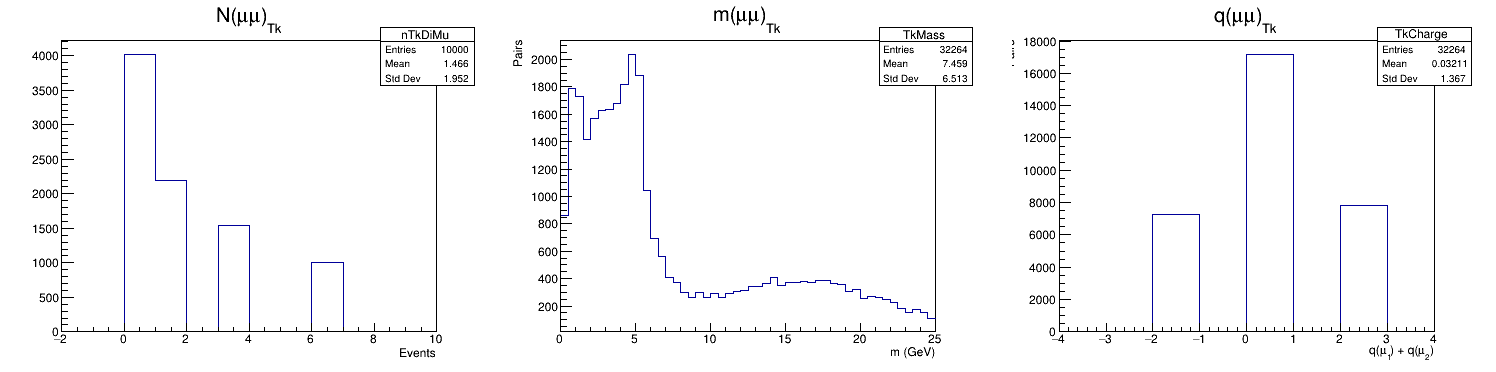

In [7]:
rdf_Tkdimu = makeDimuonPairs("Tk", rdf_gendimu)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNTkPairs = rdf_Tkdimu.Histo1D(("nTkDiMu","N(#mu#mu)_{Tk};Events",12,-2,10), "nTkDiMu")
hTkPairMass = rdf_Tkdimu.Histo1D(("TkMass","m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,25), "TkDiMu_mass")
hTkPairCharge = rdf_Tkdimu.Histo1D(("TkCharge","q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_charge")
entries_TkDiMu_full = rdf_Tkdimu.Count().GetValue()
print(f"Processed {entries_TkDiMu_full} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNTkPairs,hTkPairMass,hTkPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

Processed 10000 entries.


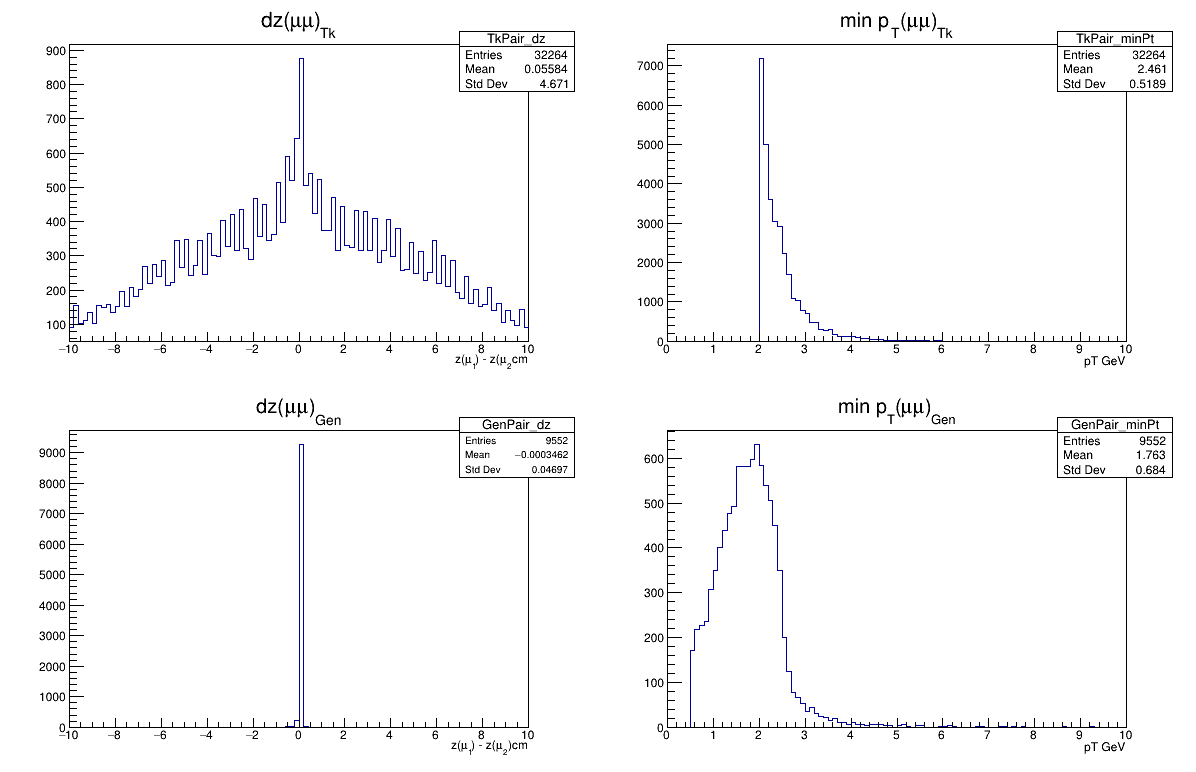

In [8]:
def dimuonextra(name,rdf):
    #separation along the beamline
    rdf=rdf.Define(f"{name}DiMu_dz",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
    return ret;""")
    #min pT of thw two
    rdf = rdf.Define(f"{name}Mu_minPT",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
    return ret;""") #
    
    return rdf;
rdf_tkextra = dimuonextra("Tk", dimuonextra("Gen", rdf_Tkdimu)) #this is done to essentially include all the newly created Rdfs in the final rdf
hTkPair_Dz = rdf_tkextra.Histo1D(("TkPair_dz","dz(#mu#mu)_{Tk};z(#mu_{1}) - z(#mu_{2}cm",100,-10,10),"TkDiMu_dz")
hTkPair_minPt = rdf_tkextra.Histo1D(("TkPair_minPt","min p_{T}(#mu#mu)_{Tk};pT GeV",100,0,10),"TkMu_minPT")
hGenPair_Dz = rdf_tkextra.Histo1D(("GenPair_dz","dz(#mu#mu)_{Gen};z(#mu_{1}) - z(#mu_{2})cm",100,-10,10),"GenDiMu_dz")
hGenPair_minPt = rdf_tkextra.Histo1D(("GenPair_minPt","min p_{T}(#mu#mu)_{Gen};pT GeV",100,0,10),"GenMu_minPT")


entries_TkDiMuExtra_full = rdf_Tkdimu.Count().GetValue()
print(f"Processed {entries_TkDiMuExtra_full} entries.")

## And plot it
c2 = ROOT.TCanvas("c2","c2", 1200, 800)
c2.Divide(2,2)
for i, h in enumerate([hTkPair_Dz, hTkPair_minPt, hGenPair_Dz, hGenPair_minPt]):
    c2.cd(i+1)
    h.Draw()
c2.Draw()

In [9]:
def select_ind(name, rdf):
    
    #Let us impose a selection criteria here
    #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
    rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.8)")                    
    rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
    rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
    rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
    rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
    rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
    return rdf;
rdf_gendisel = select_ind("Gen", rdf_tkextra)

Processed 424 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


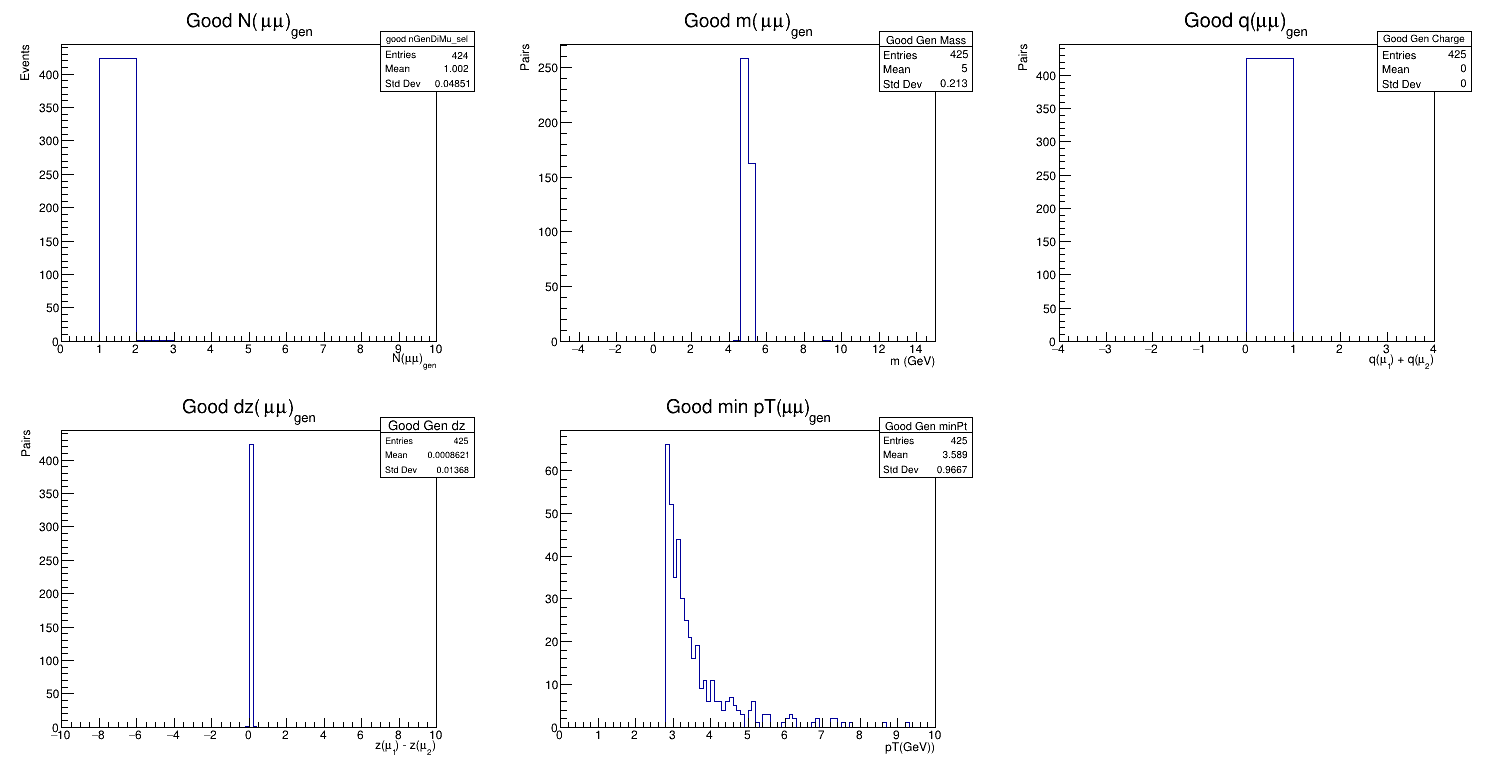

In [18]:
rdf_selFeat = rdf_gendisel
hNGoodGenPairs = rdf_selFeat.Histo1D(("good nGenDiMu_sel","Good N(#mu#mu)_{gen};N(#mu#mu)_{gen};Events",10,0,10), "nGenDiMu_sel")
hGoodGenPairMass = rdf_selFeat.Histo1D(("Good Gen Mass","Good m(#mu#mu)_{gen};m (GeV);Pairs",50,-5,15), "GenDiMu_selMass")
hGoodGenPairCharge = rdf_selFeat.Histo1D(("Good Gen Charge","Good q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "GenDiMu_selCharge")
hGoodGenPairDz = rdf_selFeat.Histo1D(("Good Gen dz","Good dz(#mu#mu)_{gen};z(#mu_{1}) - z(#mu_{2});Pairs",100,-10,10), "GenDiMu_seldz")
hGoodGenPairMinPT = rdf_selFeat.Histo1D(("Good Gen minPt","Good min pT(#mu#mu)_{gen};pT(GeV))",100,0,10), "GenDiMu_selMinPt")
#rdf_selFeat.Describe()
entries_genDi_sel1 = rdf_selFeat.Count().GetValue()
print(f"Processed {entries_genDi_sel1} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNGoodGenPairs, hGoodGenPairMass, hGoodGenPairCharge, hGoodGenPairDz, hGoodGenPairMinPT]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [11]:
rdf_select_Tk = select_ind("Tk",rdf_selFeat)
rdf_Tk_selFeat = rdf_select_Tk

Processed 183 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


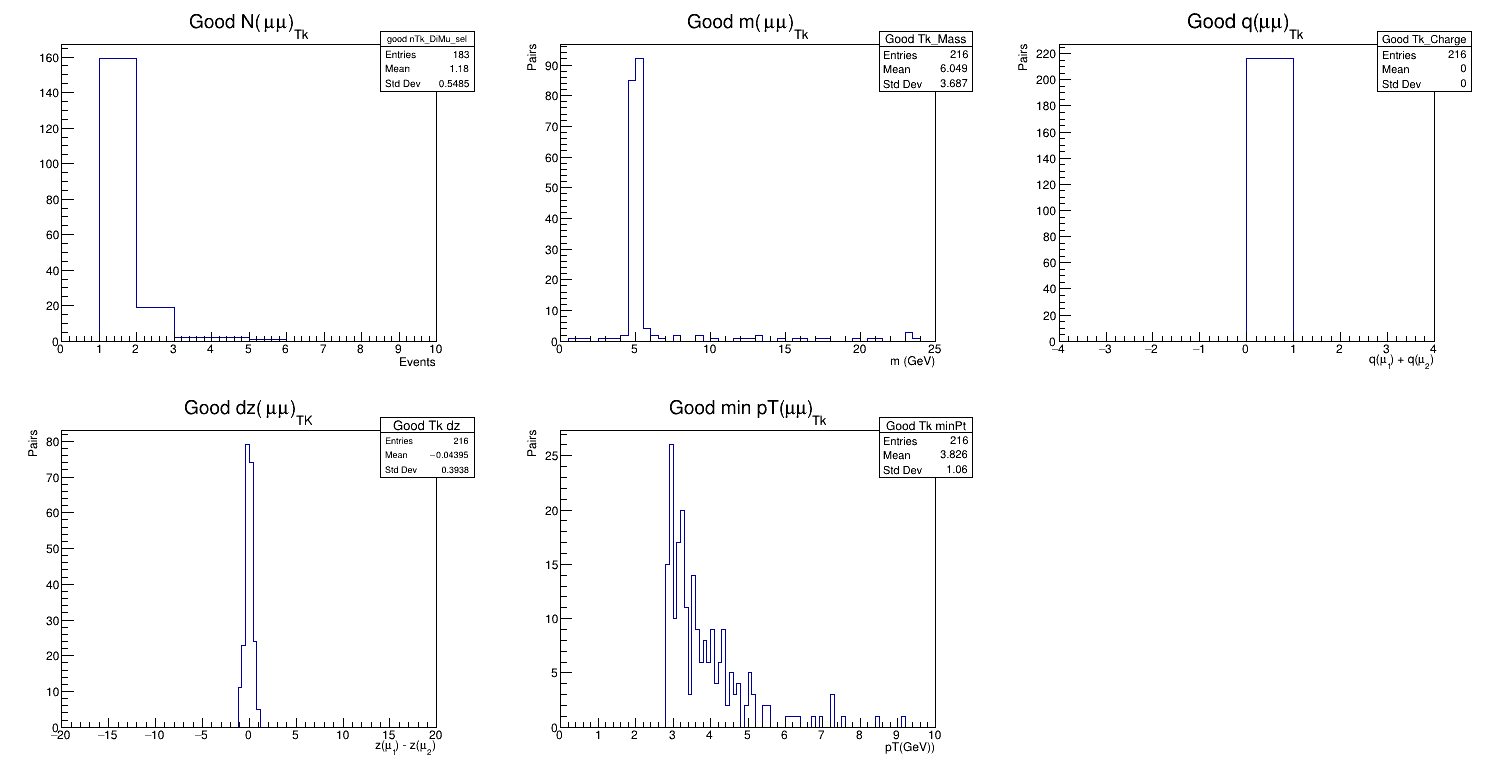

In [12]:
hNGoodTkPairs = rdf_Tk_selFeat.Histo1D(("good nTk_DiMu_sel","Good N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_sel")
hGoodTkPairMass = rdf_Tk_selFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,15), "TkDiMu_selMass")
hGoodTkPairCharge = rdf_Tk_selFeat.Histo1D(("Good Tk_Charge","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_selCharge")
hGoodTkPairDz = rdf_Tk_selFeat.Histo1D(("Good Tk dz","Good dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",100,-20,20), "TkDiMu_seldz")
hGoodTkPairMinPT = rdf_Tk_selFeat.Histo1D(("Good Tk minPt","Good min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_selMinPt")
entries = rdf_Tk_selFeat.Count().GetValue()

#rdf_selFeat.Describe()
entries_TkDi_sel1 = rdf_Tk_selFeat.Count().GetValue()
print(f"Processed {entries_TkDi_sel1} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNGoodTkPairs, hGoodTkPairMass, hGoodTkPairCharge, hGoodTkPairDz, hGoodTkPairMinPT]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [13]:
#let us impose another selection on just tracker muons
def indexSelect(rdf):
    rdf = rdf.Define("TkDiMu_indGood","(GoodTkDiMu_minIdx_Tk!=-1)" )
    rdf = rdf.Define(f"IdxDiMu_indices", f"GoodTkDiMu_indices[TkDiMu_indGood]")
    rdf = rdf.Filter(f"Sum(TkDiMu_indGood)  >= 1")
    rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
    rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_selMass[TkDiMu_indGood]")
    rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_selCharge[TkDiMu_indGood]")
    rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_seldz[TkDiMu_indGood]")
    rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkDiMu_selMinPt[TkDiMu_indGood]")
    
    return rdf;

rdf_idxSel = indexSelect(rdf_Tk_selFeat)

Processed 166 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


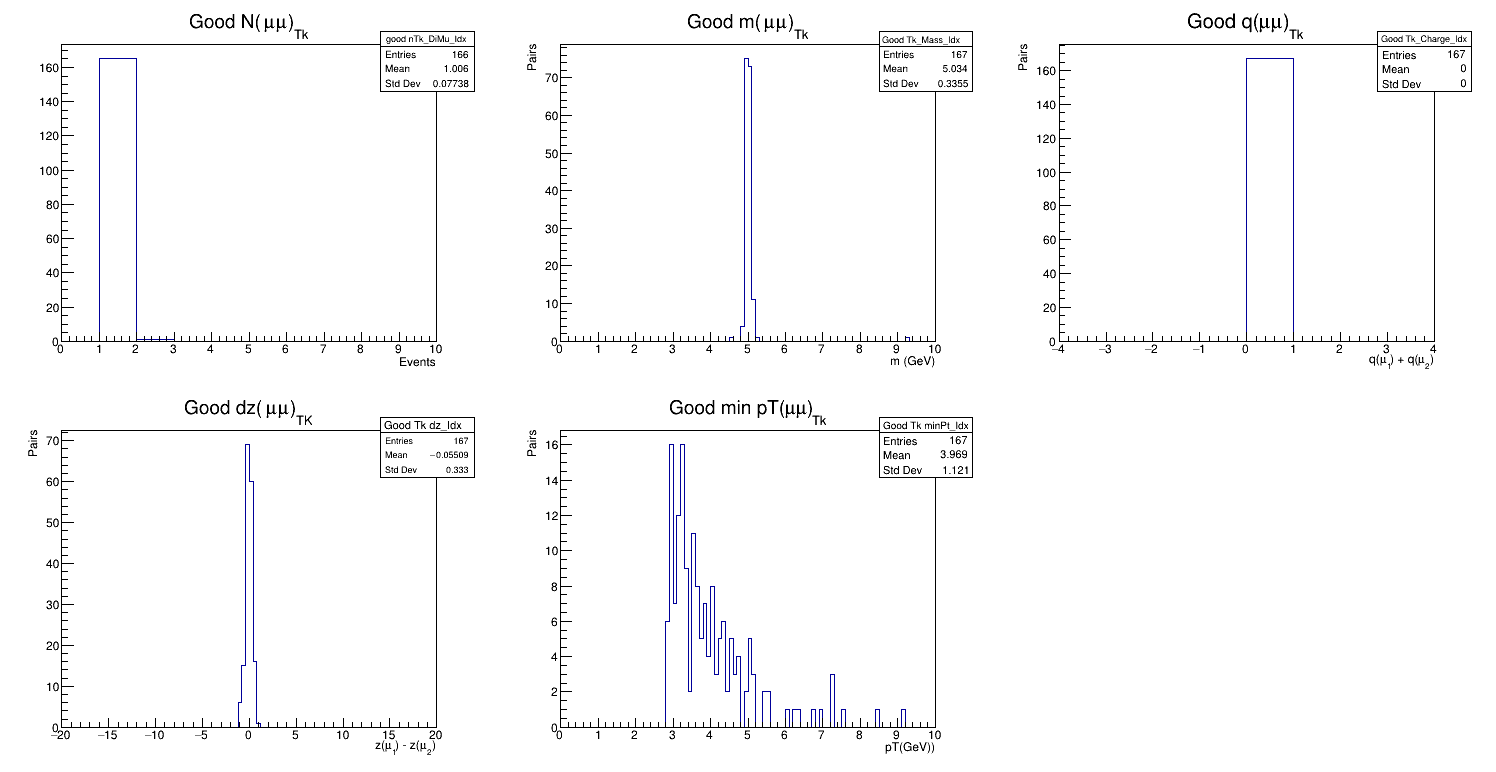

In [15]:
hNIdxTkPairs = rdf_idxSel.Histo1D(("good nTk_DiMu_Idx","Good N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_Idx")
hIdxTkPairMass = rdf_idxSel.Histo1D(("Good Tk_Mass_Idx","Good m(#mu#mu)_{Tk};m (GeV);Pairs",100,0,10), "TkDiMu_IdxMass")
hIdxTkPairCharge = rdf_idxSel.Histo1D(("Good Tk_Charge_Idx","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_IdxCharge")
hIdxTkPairDz = rdf_idxSel.Histo1D(("Good Tk dz_Idx","Good dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",100,-20,20), "TkDiMu_Idxdz")
hIdxTkPairMinPT = rdf_idxSel.Histo1D(("Good Tk minPt_Idx","Good min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_IdxMinPt")
entries_TkDi_sel2 = rdf_idxSel.Count().GetValue()
print(f"Processed {entries_TkDi_sel2} entries.")


c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNIdxTkPairs, hIdxTkPairMass, hIdxTkPairCharge, hIdxTkPairDz, hIdxTkPairMinPT]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()
#c1.SaveAs("m15_final graohs with Index cut.png")

In [19]:
efficiency_sel1 = (entries_TkDi_sel1/entries_TkDiMuExtra_full)
print(f"The efficiency of tracker muons after selection on min pT={efficiency_sel1} ")

efficiency_sel2 = (entries_TkDi_sel2/entries_TkDiMuExtra_full)
print(f"The efficiency of tracker muons after selection on min pT and muon index={efficiency_sel2} ")


The efficiency of tracker muons after selection on min pT=0.0183 
The efficiency of tracker muons after selection on min pT and muon index=0.0166 


In [20]:
A_sel1=(entries_genDi_sel1/entries_genDiMu_full)
print(f"The A of generated muons after selection on min pT={A_sel1} ")

The A of generated muons after selection on min pT=0.0424 
